# 未經雨量站校正--過去01小時雷達降水估算資料


## Header

```
      integer yyyy,mm,dd,hh,mn,ss,nx,ny,nz  ! 1-9th vars
      character proj*4                      ! 10th vars
      integer map_scale,projlat1,projlat2,projlon,alon,alat
      integer xy_scale,dx,dy,dxy_scale      ! 11-20th vars
      integer z_scale,i_bb_mode,unkn01(9)
      character varname*20,varunit*6
      integer var_scale,missing,nradar
      integer,allocatable :: zht(:)
      character,allocatable ::  mosradar(:)*4
      integer*2,allocatable :: var(:,:,:)
      integer*4,allocatable :: var4(:,:,:)
      real,allocatable :: var_true(:,:,:)

      integer*4,allocatable :: I_var_true(:,:,:)
      character var_type
      integer x,y
```

## Note

- yyyy、mm、dd、hh、mn、ss
- nx、ny :  xy網格點數(1\~441; 1\~561)
- nz : 垂直層數
- proj : 
- map_scale = 1000 
- projlat1=0
- projlat2=0
- projlon=0
- alon = 118000/map_scale (118000/1000=118.)
- alat =  27000/map_scale ( 27000/1000=27.)
  - (alon、alat為QPESUMS初始指標點，左上角；但資料存放位置由左下角開始<由左->右;由下->上>)
- xyscale=1000
- dx=1250 ; dy=1250
- dxy_scale=100000   {dx/dxy_scale => 1250/1000000.0125度(資料解析度)  }
- zht=1000(垂直層厚度)
- z_scale=1
- i_bb_mode=1
- unkn01(1-9)=信心度額外參數
  - unkn01(1)=>  佳
  - unkn01(2)=>中等
  - unkn01(3)=>不佳
  - unkn01(4)=>1000
  - unkn01(5)=>雨量站數
  - 佳=>unkn01(1)/unkn01(4)
  - 中等=>unkn01(2)/unkn01(4)
  - 不佳=>unkn01(3)/unkn01(4)

- varneme=>變數名稱
- varunit 變數單位
- var_scale=1 (變數 var 乘var_scale後存至binary)
- missing=0(無效值)
- nradar = 雷達個數
- mosradar(1-6)=雷達名稱

In [1]:
import gzip, os
# Read binary data from gz file
with gzip.open('data/PCP_1H_RAD.20140715.0700.gz', 'rb') as f:
    data0 = f.read()
print(len(data0))

494972


In [2]:
import struct
# Header section 1
yyyy,mm,dd,hh,mn,ss,nx,ny,nz = struct.unpack('iiiiiiiii', data0[:36])
print((yyyy,mm,dd,hh,mn,ss,nx,ny,nz))
# Header section 2
proj = struct.unpack('4s', data0[36:40])
print(proj[0].decode('utf-8'))
map_scale,projlat1,projlat2,projlon,alon,alat,xy_scale,dx,dy,dxy_scale = struct.unpack('iiiiiiiiii', data0[40:80])
print(map_scale,projlat1,projlat2,projlon,alon,alat,xy_scale,dx,dy,dxy_scale)
# Header section 3
zht,z_scale,i_bb_mode = struct.unpack('iii', data0[80:92])
print(zht,z_scale,i_bb_mode)
unkn01,unkn02,unkn03,unkn04,unkn05,unkn06,unkn07,unkn08,unkn09 = struct.unpack('iiiiiiiii', data0[92:128])
print(unkn01,unkn02,unkn03,unkn04,unkn05,unkn06,unkn07,unkn08,unkn09)
varname = struct.unpack('20s', data0[128:148])
varunit = struct.unpack('6s', data0[148:154])
print(varname[0].decode('ISO-8859-1'), varunit[0].decode('utf-8'))
var_scale,missing,nradar = struct.unpack('iii', data0[154:166])
print(var_scale,missing,nradar)
mosradar = struct.unpack('4s', data0[166:170])
print(mosradar)


(2014, 7, 15, 7, 0, 0, 441, 561, 1)
LL  
1000 30000 60000 120750 118000 27000 1000 1250 1250 100000
0 1 0
0 0 0 0 0 0 0 0 0
1h_rad_hsr hsr   xæ  mm 1H 
10 -999 1
(b'none',)


In [3]:
# Read data
print(nx*ny)
print(nx*ny*2+170)
var = struct.unpack('247401h', data0[170:])
print(len(var))

247401
494972
247401


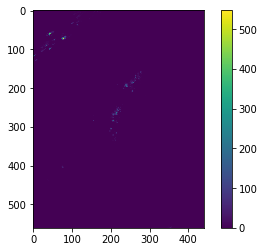

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

varnp = np.array(var).reshape(ny,nx)
plt.imshow(np.flipud(varnp))
plt.colorbar()
plt.show()

In [24]:
class cwbqpe:
    
    def __init__(self, file=None, data=None):
        self.uri = file
        self.header = None
        self.data = data
        
    def help(self):
        print("This toolset provides functions accessing CWB QPESUMS data. \nThe data is 494972 bytes binary stored in gzip format. The first 170 bytes is the header, and the latter part is the QPE results on a (441x561) surface.\n")
    
    def load_data(self, file=None):
        import os, gzip, struct
        import numpy as np
        # Check data file
        if (self.uri is None):
            if (file is None) or (not os.path.isfile(file)):
                print('[Error] The data file is not specified or does not exist.')
                return(None)
            else:
                self.uri = file
        # Load data
        with gzip.open(self.uri, 'rb') as f:
            raw = f.read()
        # Parse header
        self.header = self.parse_header(raw[:170])
        self.data = np.array(struct.unpack('247401h', raw[170:])).reshape(self.header['ny'], self.header['nx'])
        return(0)
    
    def parse_header(self, raw):
        import struct
        header = {}
        # Time information
        header['year'] = struct.unpack('i', raw[:4])[0]
        header['month'] = struct.unpack('i', raw[4:8])[0]
        header['day'] = struct.unpack('i', raw[8:12])[0]
        header['hour'] = struct.unpack('i', raw[12:16])[0]
        header['minute'] = struct.unpack('i', raw[16:20])[0]
        header['second'] = struct.unpack('i', raw[20:24])[0]
        # Data dimension
        header['nx'] = struct.unpack('i', raw[24:28])[0]
        header['ny'] = struct.unpack('i', raw[28:32])[0]
        header['nz'] = struct.unpack('i', raw[32:36])[0]
        # Projection and lat/lon
        header['proj'] = struct.unpack('4s', raw[36:40])[0].decode('ISO-8859-1')
        header['map_scale'] = struct.unpack('i', raw[40:44])[0]
        header['projlat1'] = struct.unpack('i', raw[44:48])[0]
        header['projlat2'] = struct.unpack('i', raw[48:52])[0]
        header['projlon'] = struct.unpack('i', raw[52:56])[0]
        header['alon'] = struct.unpack('i', raw[56:60])[0]
        header['alat'] = struct.unpack('i', raw[60:64])[0]
        # Delta in x-y-z
        header['pxy_scale'] = struct.unpack('i', raw[64:68])[0]
        header['dx'] = struct.unpack('i', raw[68:72])[0]
        header['dy'] = struct.unpack('i', raw[72:76])[0]
        header['dxy_scale'] = struct.unpack('i', raw[76:80])[0]
        header['zht'] = struct.unpack('i', raw[80:84])[0]
        header['z_scale'] = struct.unpack('i', raw[84:88])[0]
        header['i_bb_mode'] = struct.unpack('i', raw[88:92])[0]
        # Quality information
        unkn01,unkn02,unkn03,unkn04,unkn05,unkn06,unkn07,unkn08,unkn09 = struct.unpack('iiiiiiiii', raw[92:128])
        # Variable information
        header['varname'] = struct.unpack('20s', raw[128:148])[0].decode('ISO-8859-1')
        header['varunit'] = struct.unpack('6s', raw[148:154])[0].decode('ISO-8859-1')
        header['var_scale'] = struct.unpack('i', raw[154:158])[0]
        header['missing'] = struct.unpack('i', raw[158:162])[0]
        header['nradar'] = struct.unpack('i', raw[162:166])[0]
        header['mosradar'] = struct.unpack('4s', raw[166:170])[0].decode('ISO-8859-1')
        #
        return(header)

    def find_nearest_value(self, lon, lat):
        ''' Find the closest point in the dataset to the specified lon/lat.'''
        import numpy as np
        # Check data file
        if (self.header is None):
            print('[Error] The object has not yet been initialized.')
            return(None)
        # Derive the coordinate of the data object
        lon0 = self.header['alon']/self.header['map_scale']
        lat1 = self.header['alat']/self.header['map_scale']
        dx = self.header['dx']/self.header['dxy_scale']
        dy = self.header['dy']/self.header['dxy_scale']
        lon1 = lon0 + (self.header['nx']-1)*dx
        lat0 = lat1 - (self.header['ny']-1)*dy
        lons = np.linspace(lon0, lon1, self.header['nx'])
        lats = np.linspace(lat0, lat1, self.header['ny'])
        # Check boundaries
        if (lon<lon0) or (lon>lon1) or (lat<lat0) or (lat>lat1):
            print("Specified lon/lat is outside of the data boundary: "+
                  str(lon0)+"~"+str(lon1)+", "+str(lat0)+"~"+str(lat1))
            return(None)
        # Find neighbors
        ilonr = np.where(lons>lon)[0][0]
        ilonl = np.where(lons<=lon)[0][-1]
        ilatu = np.where(lats>lat)[0][0]
        ilatd = np.where(lats<=lat)[0][-1]
        # Determin the closest point
        if (lon - lons[ilonl]) <= (lons[ilonr] - lon):
            ilon = ilonl
        else:
            ilon = ilonr
        if (lat - lats[ilatd]) <= (lats[ilatu] - lat):
            ilat = ilatd
        else:
            ilat = ilatu
        #
        return((lons[ilon], lats[ilat], self.data[ilat,ilon]))

    def find_interpolated_value(self, lon, lat):
        ''' Find the closest points and interpolate to the specified lon/lat.'''
        import numpy as np
        # Check data file
        if (self.header is None):
            print('[Error] The object has not yet been initialized.')
            return(None)
        # Derive the coordinate of the data object
        lon0 = self.header['alon']/self.header['map_scale']
        lat1 = self.header['alat']/self.header['map_scale']
        dx = self.header['dx']/self.header['dxy_scale']
        dy = self.header['dy']/self.header['dxy_scale']
        lon1 = lon0 + (self.header['nx']-1)*dx
        lat0 = lat1 - (self.header['ny']-1)*dy
        lons = np.linspace(lon0, lon1, self.header['nx'])
        lats = np.linspace(lat0, lat1, self.header['ny'])
        # Check boundaries
        if (lon<lon0) or (lon>lon1) or (lat<lat0) or (lat>lat1):
            print("Specified lon/lat is outside of the data boundary: "+
                  str(lon0)+"~"+str(lon1)+", "+str(lat0)+"~"+str(lat1))
            return(None)
        # Find neighbors
        ilonr = np.where(lons>lon)[0][0]
        ilonl = np.where(lons<=lon)[0][-1]
        ilatu = np.where(lats>lat)[0][0]
        ilatd = np.where(lats<=lat)[0][-1]
        # Interpolate
        def bilinear_interpolation(x, y, x1, x2, y1, y2, z):
            '''Bilinear interpolation, ref:https://en.wikipedia.org/wiki/Bilinear_interpolation'''
            A = np.array([[1,x1,y1,x1*y1],[1,x1,y2,x1*y2],[1,x2,y1,x2*y1],[1,x2,y2,x2*y2]])
            a = np.linalg.solve(A,z)
            fxy = a[0] + a[1]*x + a[2]*y + a[3]*x*y
            return(fxy)
        #
        neighbours = [self.data[ilatd,ilonl], self.data[ilatu,ilonl], self.data[ilatd,ilonr], self.data[ilatu,ilonr]]
        value = bilinear_interpolation(lon, lat, lons[ilonl], lons[ilonr], lats[ilatd], lats[ilatu], neighbours)
        return(value)

    

## Test Class Design

### Data Loading

This is a simple class, so there is no encapsulation required.

In [20]:
# Test Object
cq = cwbqpe()
print(cq.uri)
print(cq.header)
print(cq.data)

# Test reding data
cq.load_data('data/PCP_1H_RAD.20140715.0700.gz')
for k,v in cq.header.items():
    print(k +":\t"+str(v))
print(cq.data.shape)

None
None
None
year:	2014
month:	7
day:	15
hour:	7
minute:	0
second:	0
nx:	441
ny:	561
nz:	1
proj:	LL  
map_scale:	1000
projlat1:	30000
projlat2:	60000
projlon:	120750
alon:	118000
alat:	27000
pxy_scale:	1000
dx:	1250
dy:	1250
dxy_scale:	100000
zht:	0
z_scale:	1
i_bb_mode:	0
varname:	1h_rad_hsr hsr   xæ 
varunit:	mm 1H 
var_scale:	10
missing:	-999
nradar:	1
mosradar:	none
(561, 441)


### Data Showing

By definition, data in the header needs to be scaled properly to represent the actual units.

In [7]:
# Add coornidate to the data (lon/lat)
lon0 = cq.header['alon']/cq.header['map_scale']
lat1 = cq.header['alat']/cq.header['map_scale']

dx = cq.header['dx']/cq.header['dxy_scale']
dy = cq.header['dy']/cq.header['dxy_scale']

lon1 = lon0 + (cq.header['nx']-1)*dx
lat0 = lat1 - (cq.header['ny']-1)*dy

print(lon0, lon1, dx)
print(lat0, lat1, dy)

118.0 123.5 0.0125
20.0 27.0 0.0125


### Show data on map

To see if the data loader works properly. It turns out the time-stamp is in UTC.

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


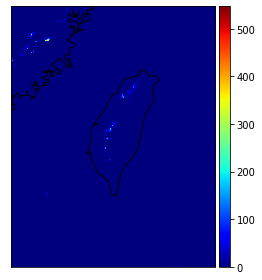

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


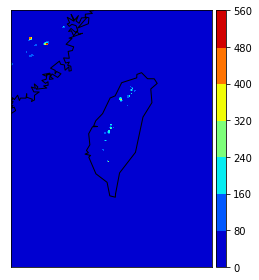

In [8]:
# Show data
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

lons = np.linspace(lon0, lon1, cq.header['nx'])
lats = np.linspace(lat0, lat1, cq.header['ny'])
x,y = np.meshgrid(lons, lats)

m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
m.drawcoastlines()

m.imshow(cq.data, cmap=plt.cm.jet)
m.colorbar()

plt.tight_layout()
plt.show()

m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
m.drawcoastlines()

m.contourf(x, y, cq.data, cmap=plt.cm.jet)
m.colorbar()

plt.tight_layout()
plt.show()

## Find the nearest grid point

By specifying the lon/lat, we device a function to find the nearest grid point and return the lon/lat/value of that grid point.

In [9]:
# Convert lon/lat to grid point
def find_nearest_value(lon, lat, cq):
    # Derive the coordinate of the data object
    lon0 = cq.header['alon']/cq.header['map_scale']
    lat1 = cq.header['alat']/cq.header['map_scale']
    dx = cq.header['dx']/cq.header['dxy_scale']
    dy = cq.header['dy']/cq.header['dxy_scale']
    lon1 = lon0 + (cq.header['nx']-1)*dx
    lat0 = lat1 - (cq.header['ny']-1)*dy
    lons = np.linspace(lon0, lon1, cq.header['nx'])
    lats = np.linspace(lat0, lat1, cq.header['ny'])
    # Check boundaries
    if (lon<lon0) or (lon>lon1) or (lat<lat0) or (lat>lat1):
        print("Specified lon/lat is outside of the data boundary: "+str(lon0)+"~"+str(lon1)+", "+str(lat0)+"~"+str(lat1))
        return(None)
    # Find neighbors
    ilonr = np.where(lons>lon)[0][0]
    ilonl = np.where(lons<=lon)[0][-1]
    ilatu = np.where(lats>lat)[0][0]
    ilatd = np.where(lats<=lat)[0][-1]
    # Determin the closest point
    if (lon - lons[ilonl]) <= (lons[ilonr] - lon):
        ilon = ilonl
    else:
        ilon = ilonr
    if (lat - lats[ilatd]) <= (lats[ilatu] - lat):
        ilat = ilatd
    else:
        ilat = ilatu
    #
    return((lons[ilon], lats[ilat], cq.data[ilon,ilat]))

In [10]:
# Test find closest grid point
xs = np.linspace(0,10,20)
ys = np.linspace(0,10,20)
print(xs)
print(ys)

px, py = (3.2, 5.8)

xr = xs[np.where((xs>px),)[0][0]]
xl = xs[np.where((xs<=px),)[0][-1]]

print(xl, xr)

[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]
[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]
3.1578947368421053 3.6842105263157894


In [11]:
find_closest_value(120.4329, 23.4959, cq)

(120.4375, 23.5, 0)

In [12]:
# Test
xs, ys = np.where(cq.data>100)
print(xs[0], ys[0])
xlon = lon0 + xs[0]*dx
xlat = lat0 + ys[0]*dy
print(xlon, xlat)
print(cq.data[xs[0], ys[0]])
find_closest_value(120.882, 22.664, cq)

230 213
120.875 22.6625
269


(120.8875, 22.6625, 30)

## Interpolation

### [Bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation)

Assumed that we know the value of f at the four points Q11 = (x1, y1), Q12 = (x1, y2), Q21 = (x2, y1), and Q22 = (x2, y2).

$f(x,y) \sim a_0 + a_1x + a_2y + a_3xy$

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/ea0d3dc173ca61ce1821304299e852a7aeed4176' />

In [13]:
import numpy as np

# Solve linear system with numpy
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html

x1 = 0.
x2 = 1.
y1 = 0.
y2 = 1.
z = [1.,2.,3.,4.]

def bilinear_interpolation(x, y, x1, x2, y1, y2, z):
    A = np.array([[1,x1,y1,x1*y1],[1,x1,y2,x1*y2],[1,x2,y1,x2*y1],[1,x2,y2,x2*y2]])
    a = np.linalg.solve(A,z)
    fxy = a[0] + a[1]*x + a[2]*y + a[3]*x*y
    return(fxy)

print(bilinear_interpolation(0.5,0.5, x1, x2, y1, y2, z))
print(bilinear_interpolation(0.3,0.6, x1, x2, y1, y2, z))

2.5
2.2


In [15]:
# Test interpolation
cq.find_interpolated_value(120.882, 22.664)

118.94080018997192

## Test with Station List

We will read in the list of weather stations with their ID, lon/lat, altitude,..., and retrieve the QPE value.


In [2]:
import pandas as pd

stalist = pd.read_csv('data/stationlist.txt')

stalist.head()

,STN#,Elevation,Lon,Lat,Unnamed: 4
0,466850,756.0,121.7812,25.0712,NaN
1,466880,9.7,121.4420,24.9976,NaN
2,466900,19.0,121.4489,25.1649,NaN
3,466910,825.8,121.5297,25.1826,NaN
4,466920,6.3,121.5149,25.0377,NaN


In [25]:
# Load QPE data
cq = cwbqpe('data/PCP_1H_RAD.20140715.0700.gz')
cq.load_data()

# For output
qpeval = []
# Loop through stations 
for i in range(stalist.shape[0]):
    sta = stalist.iloc[i,:]
    print((sta['STN#'], sta['Lon'], sta['Lat']))
    qval = cq.find_interpolated_value(sta['Lon'], sta['Lat'])
    print(qval)
    qpeval.append({'id':sta['STN#'], 'qpe':qval})

qpeval = pd.DataFrame(qpeval)

('466850', 121.7812, 25.0712)
0.0
('466880', 121.44200000000001, 24.9976)
12.70880001783371
('466900', 121.4489, 25.1649)
0.0
('466910', 121.5297, 25.1826)
0.0
('466920', 121.5149, 25.0377)
0.0
('466930', 121.5445, 25.1621)
0.0
('466940', 121.7405, 25.1333)
0.0
('466950', 122.0797, 25.628)
0.0
('466990', 121.6133, 23.9751)
0.0
('467050', 121.0475, 25.0067)
0.0
('467060', 121.8574, 24.5967)
0.0
('467080', 121.7565, 24.764)
0.0
('467110', 118.2893, 24.4073)
0.0
('467300', 119.6675, 23.256999999999998)
0.0
('467350', 119.5631, 23.5655)
0.0
('467410', 120.2048, 22.9932)
0.0
('467420', 120.2367, 23.0384)
0.0
('467440', 120.3157, 22.566)
0.0
('467480', 120.4329, 23.4959)
0.0
('467490', 120.6841, 24.1457)
0.0
('467530', 120.8132, 23.5082)
1.8880000000026484
('467540', 120.9038, 22.3557)
0.0
('467550', 120.9595, 23.4876)
0.0
('467571', 121.0142, 24.8279)
0.0
('467590', 120.7463, 22.0039)
0.0
('467610', 121.3734, 23.0975)
0.0
('467620', 121.5583, 22.037)
0.0
('467650', 120.9081, 23.8813)
0.0
('

0.0
('C1T950', 121.3701, 23.6667)
0.0
('C1T970', 121.4133, 23.6152)
0.0
('C1T980', 121.4113, 24.0233)
0.0
('C1T990', 121.3568, 23.3942)
0.0
('C1U501', 121.5737, 24.6378)
0.0
('C1U511', 121.6716, 24.5716)
0.0
('C1U670', 121.7169, 24.634)
0.0
('C1U690', 121.7513, 24.6256)
0.0
('C1U830', 121.8394, 24.4827)
0.0
('C1U840', 121.8485, 24.5378)
0.0
('C1U850', 121.7786, 24.3832)
0.0
('C1U880', 121.8719, 24.9065)
0.0
('C1V160', 120.7053, 23.2798)
0.0
('C1V170', 120.9541, 23.4636)
0.0
('C1V190', 120.9118, 23.274)
0.0
('C1V200', 120.8236, 23.2684)
0.0
('C1V220', 120.8136, 23.1542)
0.0
('C1V231', 120.7167, 23.1349)
0.0
('C1V300', 120.7154, 23.002)
0.0
('C1V340', 120.646, 22.8883)
97.09311997890472
('C1V390', 120.3678, 22.8132)
0.0
('C1V570', 120.5454, 22.8542)
0.0
('C1V580', 120.7885, 23.085)
0.0
('C1V590', 120.6461, 23.057)
8.50495994091034
('C1V600', 120.757, 23.072)
0.0
('C1V780', 120.7379, 22.888)
0.0
('C1X040', 120.4638, 23.2916)
0.0
('C1Z030', 121.3388, 23.4931)
0.0
('C1Z040', 121.3274, 23.44

OK, the debug is done. let's proceed with the full datasaet.